添加引用

In [1]:
import utils
import params
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np


Using TensorFlow backend.


从Tesla数据集的视频中，得到训练图片。从数据集的车辆转向记录中读取转向数据，将转向数据和训练图片做一一对应，得到训练数据集。

In [34]:
def img_pre_process(img, resize_w, resize_h):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :return: Returns the processed image
    """
    ## Chop off 1/3 from the top and cut bottom 150px(which contains the head of car)
    shape = img.shape
#    print("shape  ", shape)
    img = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    ## Resize the image
    img = cv2.resize(img, (resize_w, resize_h), interpolation=cv2.INTER_AREA)
    ## Return the image sized as a 4D array
    return np.resize(img, (resize_w, resize_h, params.FLAGS.img_c))

In [223]:
from sklearn.model_selection import train_test_split

#加载epoch1到epoch9的所有视频的图片到img_list中，加载epoch1到epoch9的所有转向数据到steer_list，
def loadVideoAndResize(resize_w, resize_h):
    for epoch_id in range(1,11):    
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv').format(epoch_id)
        steer_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv').format(epoch_id)
        steer_data = utils.fetch_csv_data(steer_path)
    
        steer_list = steer_data['wheel'] 
    
        frame_count = utils.frame_count(vid_path)
        cap = cv2.VideoCapture(vid_path)
        img_list = []
    
        for frame_id in range(frame_count):
            ret, img = cap.read()       
            img_resized = img_pre_process(img, resize_w, resize_h)
            img_list.append(img_resized)
        
            if frame_id == frame_count - 1 and epoch_id == 9:
                print("img pre shape {}".format(img.shape))
                print("img after shape {}".format(img_resized.shape))
                plt.imshow(img)
                plt.show()
                plt.imshow(img_resized)
                plt.show()
    
    #随机打乱数据，取10%的训练数据做验证集
        img_list_train, img_list_val, steer_list_train, steer_list_val = train_test_split(img_list, steer_list, test_size=0.1, random_state=10)
    
    #把训练集和验证集存到本地
        train_add = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(epoch_id, resize_w,resize_h)
        val_add = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(epoch_id, resize_w,resize_h)
        pickle.dump((img_list_train, steer_list_train), open(train_add, 'wb'))
        pickle.dump((img_list_val, steer_list_val), open(val_add, 'wb'))





img pre shape (720, 1280, 3)
img after shape (32, 32, 3)


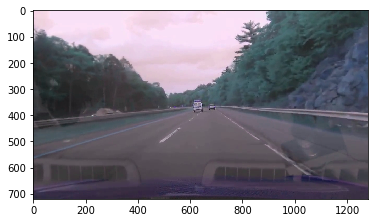

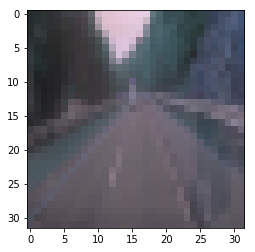

In [224]:
loadVideoAndResize(32, 32)

加载数据

In [38]:

def load_preprocess_training_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_train.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer
def load_preprocess_validating_batch(batch_id, resize_w, resize_h):
    filename = 'epoch{:0>2}_{}_{}_preprocess_val.p'.format(batch_id, resize_w, resize_h)
    img, steer = pickle.load(open(filename, mode='rb'))

    return img, steer

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
seed = 10

In [208]:
def nor_output(pre_y):
    pre = pre_y.reshape(1, -1)[0]
    for i, x in enumerate(pre):
        pre[i] = round(x, 4)

    for i,x in enumerate(pre):
        if x > 0:
            if (x-math.floor(x))>=0.75:
                pre[i] = int(x) + 1.0
            elif (x-math.floor(x))>=0.25:
                pre[i] = (int(x) + 0.5)
            else:
                pre[i] = int(x)
        else:
            if (x-int(x))<=-0.75:
                pre[i] = int(x) - 1.0
            elif (x-int(x))<=-0.25:
                pre[i] = (int(x) - 0.5)
            else:
                pre[i] = int(x)
    return pre

In [202]:
def simple_model_1(time_len=1):
      ch, row, col = 3, 64, 64  # camera format

      model = Sequential()
      model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
      model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
      model.add(ELU())
      model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
      model.add(ELU())
      model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
      model.add(Flatten())
      model.add(Dropout(.2))
      model.add(ELU())
      model.add(Dense(512))
      model.add(Dropout(.5))
      model.add(ELU())
      model.add(Dense(1))
    #  model.add(Lambda(nor_output_1))
      model.compile(loss='mean_absolute_error', optimizer='rmsprop')

      

      return model

In [150]:
def simple_model_2(time_len=1):
      ch, row, col = 3, 32, 32  # camera format

      model = Sequential()
      model.add(Lambda(lambda x: x/255.0,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
      model.add(Conv2D(128,kernel_size =(3,3), strides=(1, 1), padding="same", activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
      model.add(Conv2D(256,kernel_size =(1,1), strides=(1, 1), padding="same", activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
      model.add(Conv2D(384,kernel_size =(9,9), strides=(1, 1), padding="same", activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
      model.add(Conv2D(512,kernel_size =(1,1), strides=(1, 1), padding="same", activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
      model.add(Flatten())
      
      model.add(Dense(1024, activation='relu'))
      model.add(Dropout(.6))
      model.add(Dense(1))

      model.compile(loss='mean_absolute_error', optimizer='sgd')

      

      return model

In [220]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def inceptionV3_model(time_len=1):
# create the base pre-trained model 299 * 299
    base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
    x = base_model.output
  #  x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
  #  x = Dense(1, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1)(x)

# this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='sgd', loss='mean_absolute_error')

# train the model on the new data for a few epochs
    

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
    for i, layer in enumerate(base_model.layers):
       print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
   # for layer in model.layers[:249]:
   #    layer.trainable = False
   # for layer in model.layers[249:]:
   #    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
   # from keras.optimizers import SGD
   # model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='mean_absolute_error')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
   # model.fit_generator(...)
    return model

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

def restNet_model(time_len=1):
    #224 * 224
    base_model = ResNet50(weights='imagenet')

    x = base_model.output
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='sgd', loss='mean_absolute_error')
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)
    return model

In [225]:
batch_size = 64
epoches = 5

In [217]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
from decimal import Decimal
def train_model(video_list, x_val, y_val, model_func, resize_w, resize_h, ifSave = False):
    model = model_func()
    for epoch_idx in range(1, (len(video_list) * epoches) + 1) :
        
        video_idx = epoch_idx % len(video_list)
        if video_idx == 0:
            video_idx = len(video_list)
        print("train epoch_idx {} video_idx{}".format(epoch_idx, video_idx))
        x_train, y_train = load_preprocess_training_batch(video_idx, resize_w, resize_h)
        x_train = np.array(x_train).transpose(0, 3, 2, 1)
        model.fit(x_train, y_train, nb_epoch = 1, batch_size = batch_size)
    pre = model.predict(x_val, batch_size=batch_size, verbose=0)
    pre = nor_output(pre)
  #  print (pre)
    score = r2_score(y_val, pre)
    print("score: %.2f " % (score))
    if ifSave == True:
        utils.save_model(model)

    if type(y_val) != np.array:
        y_val = np.array(y_val)
    y_val = y_val.reshape(len(list(y_val)), 1)    
    y_val = y_val.reshape(1, -1)[0]
 #   print (pre.shape)
 #   print (y_val.shape)
    x = np.arange(1, len(y_val) + 1)
    y = y_val  - pre ;
 #   print(y.shape)
    plt.plot(x, abs(y) , marker = '.', color = 'b', label = 'steer bias',linewidth=0.1)
  #  plt.scatter(x, abs(y), marker = '.', color = 'g', label = 'predited steer')
    plt.show()

训练单个视频

In [228]:
res_w = 32
res_h = 32


In [ ]:
img_val, steer_val = load_preprocess_validating_batch(1, res_w, res_h)
img_val = np.array(img_val).transpose(0, 3, 2, 1)

train_model([1], np.array(img_val), steer_val, inceptionV3_model, res_w, res_h, ifSave = True)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of bcbd6486424b2319ff4ef7d526e38f63 so we will re-download the data.
75014144/87910968 [========================>.....] - ETA: 1:08

训练全部视频

In [229]:
img_test, steer_test = load_preprocess_validating_batch(10, res_w, res_h)
img_test = np.array(img_test).transpose(0, 3, 2, 1)
train_model(range(1, 10), np.array(img_test), steer_test, simple_model_2, res_w, res_h, ifSave = True)

train epoch_idx 1 video_idx1
Epoch 1/1


/Users/sengled/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1350/1350 [==============================] - 52s 39ms/step - loss: 2.6491
train epoch_idx 2 video_idx2
Epoch 1/1
3510/3510 [==============================] - 140s 40ms/step - loss: 1.3719
train epoch_idx 3 video_idx3
Epoch 1/1
2430/2430 [==============================] - 95s 39ms/step - loss: 1.4477
train epoch_idx 4 video_idx4
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 7.5225
train epoch_idx 5 video_idx5
Epoch 1/1
2430/2430 [==============================] - 88s 36ms/step - loss: 3.3527
train epoch_idx 6 video_idx6
Epoch 1/1
2430/2430 [==============================] - 127s 52ms/step - loss: 4.5391
train epoch_idx 7 video_idx7
Epoch 1/1
2430/2430 [==============================] - 108s 44ms/step - loss: 2.4922
train epoch_idx 8 video_idx8
Epoch 1/1
2430/2430 [==============================] - 90s 37ms/step - loss: 3.3254
train epoch_idx 9 video_idx9
Epoch 1/1
2430/2430 [==============================] - 91s 38ms/step - loss: 1.1742
train epoch_idx 10 

KeyboardInterrupt: 